In [1]:
from __future__ import annotations
import jijmodeling as jm
import jijmodeling_transpiler.core as jtc
import jijmodeling_transpiler_quantum.core as jtqc
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jq_qu

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import matplotlib.pyplot as plt

import openjij as oj

import numpy as np
import matplotlib.pyplot as plt

from itertools import product, islice
from dwave_qbsolv import QBSolv
import math
import copy

from dwave.samplers import SteepestDescentSampler #, SimulatedAnnealingSampler
from neal import SimulatedAnnealingSampler
from tabu import TabuSampler


In [2]:
np.set_printoptions(precision=5)


loc_num = 16
print("required_qubo_size = ", loc_num**2)



required_qubo_size =  256


In [127]:
from geopy.distance import geodesic


def geo_dis_cal(sol_res):
    total_distance = 0
    for i_ in range(len(sol_res)-1):
        # print("location ", sol_res[i_], sol_res[i_+1])
        total_distance += geodesic(
            (x_pos[sol_res[i_]], y_pos[sol_res[i_]]),
            (x_pos[sol_res[i_+1]], y_pos[sol_res[i_+1]])).kilometers
        
    return total_distance

def generate_random_instance(n,  X_range, Y_range):
    x_pos = [np.random.randint(0, X_range) for _ in range(n)]
    y_pos = [np.random.randint(0, Y_range) for _ in range(n)]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    
    return x_pos, y_pos, distance

def generate_ulysses16_instance():
    x_pos = [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
    y_pos = [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44,  9.10, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    # distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    distances = np.zeros((16, 16))
    for i in range(16):
        for j in range(i+1, 16):
            distances[i][j] = geodesic(
            (x_pos[i], y_pos[i]),
            (x_pos[j], y_pos[j])).kilometers / 100  #np.sqrt((x_pos[i] - x_pos[j])**2 + (y_pos[i] - y_pos[j])**2)
            distances[j][i] = distances[i][j]
                
    return x_pos, y_pos, distances

In [128]:
x_pos, y_pos, distance = generate_ulysses16_instance()  #generate_ulysses16_instance()  #generate_random_instance(loc_num, 100, 100)

distance_dict = {}
for ind_i, i in enumerate(distance):
    for ind_j, j in enumerate(i):
        if ind_j > ind_i:
            distance_dict[(ind_i, ind_j)] = distance[ind_i][ind_j]

print("x_pos: ", x_pos)
print("y_pos: ", y_pos)
print("distance: ", distance)

x_pos:  [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
y_pos:  [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44, 9.1, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
distance:  [[ 0.       5.18389  4.94337  3.25037 10.36073  7.2752   6.39312  0.79935
  10.24668  7.10512 22.81829  4.63025  4.44186  4.68886  6.23492  1.4505 ]
 [ 5.18389  0.       1.30756  4.53768 15.49878 12.35631 11.35861  5.47195
  14.56729 11.25574 27.73744  9.61513  9.49958  9.83519 11.38298  5.67464]
 [ 4.94337  1.30756  0.       5.14493 15.28981 11.82919 10.75944  5.40589
  13.66873 10.35796 27.01681  9.05895  8.99424  9.41083 11.16558  5.09763]
 [ 3.25037  4.53768  5.14493  0.      11.89848  9.84085  9.18306  2.7679
  13.35794 10.30531 25.39739  7.48769  7.20681  7.21917  7.98988  4.65388]
 [10.36073 15.49878 15.28981 11.89848  0.       4.76752  5.95083 10.03092
   8.69503  8.81868 14.68445  6.91112  6.76128  6.13346  4.12592 10.38332]
 [ 7.

#### Augmented Lagrangian Method  

ALM:  
https://aqc2021.org/poster2/a/A7.pdf?fbclid=IwAR3XR0aVMiBjNm7ciLXKpMSrOiMJXuhNmMRTG19Zm2_Y3A_aIY0NYXTT-sU

Mapping constraints to penalty:  
https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf

In [129]:

def decode_path(binary_array):
    path = [0 for i in range(binary_array.shape[0])]
    
    for t in range(binary_array.shape[1]):  # Iterate through each column (step)
        for i in range(binary_array.shape[0]):  # Iterate through each row (location)
            if binary_array[i, t] == 1:
                path[t] = i  # Record the location and step
                break  # Move to the next step once the location is found
    return path

def check_unique_elements(array):
    """ Check if all elements in the numpy array are unique (non-repeated) """
    unique_elements = np.unique(array)
    return unique_elements.size == array.size


def g_m_c(sample_):
    sum_loc_cons_linear = 0 
    # i = 0
    for i in range(loc_num):
        for t in range(loc_num):
            sum_loc_cons_linear += sample_[compiled_instance.var_map.var_map['x'][(i,t)]]
        sum_loc_cons_linear -= 1
        
    for t in range(loc_num):
        for i in range(loc_num):
            sum_loc_cons_linear += sample_[compiled_instance.var_map.var_map['x'][(i,t)]]
        sum_loc_cons_linear -= 1
        
    return sum_loc_cons_linear


def dis_calculate(distance_dict, sequence):
    """
    Calculate the total distance give the distance dict and path (location sequence)
    """
    total_distance = 0

    for i in range(len(sequence) - 1):
        current_location = sequence[i]
        next_location = sequence[i + 1]
        edge = (current_location, next_location)

        # Ensure the edge exists in the distance dictionary
        if edge in distance_dict:
            total_distance += distance_dict[edge]
        else:
            total_distance += distance_dict[edge[::-1]]

    return total_distance

In [130]:
def tsp_problem_ALM()-> jm.Problem:
    # Slight difference has been made compared to https://github.com/Jij-Inc/JijModelingTranspilerQuantum/blob/main/notebook/tsp_qaoa_tutorial_quri.ipynb to make the code work. 
    # Since some of the packages seems updated. 

    # define variables
    d = jm.Placeholder('d', ndim=2)
    N =d.len_at(0, latex="N")
    i = jm.Element("i", belong_to=(0, N)) # city index
    j = jm.Element('j', belong_to=(0, N)) # city index 
    t = jm.Element('t', belong_to=(0, N)) # time index or step index
    x = jm.BinaryVar("x", shape=(N, N))

    # set problem
    problem = jm.Problem('TSP')
    problem += jm.sum(i, jm.sum((j, j!=i) , d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N])))
    
    problem += jm.Constraint("one-city",x[:, t].sum() == 1, forall=t)
    problem += jm.Constraint("one-time", x[i, :].sum() == 1, forall=i)
    
    problem += jm.CustomPenaltyTerm('one-city linear', -1*jm.sum(i,x[i, t] - 1), forall=t  )
    problem += jm.CustomPenaltyTerm('one-time linear', -1*jm.sum(t,x[i, t] - 1), forall=i  )

    problem
    return problem

In [131]:
problem = tsp_problem_ALM()
problem

In [132]:
distance

array([[ 0.     ,  5.18389,  4.94337,  3.25037, 10.36073,  7.2752 ,
         6.39312,  0.79935, 10.24668,  7.10512, 22.81829,  4.63025,
         4.44186,  4.68886,  6.23492,  1.4505 ],
       [ 5.18389,  0.     ,  1.30756,  4.53768, 15.49878, 12.35631,
        11.35861,  5.47195, 14.56729, 11.25574, 27.73744,  9.61513,
         9.49958,  9.83519, 11.38298,  5.67464],
       [ 4.94337,  1.30756,  0.     ,  5.14493, 15.28981, 11.82919,
        10.75944,  5.40589, 13.66873, 10.35796, 27.01681,  9.05895,
         8.99424,  9.41083, 11.16558,  5.09763],
       [ 3.25037,  4.53768,  5.14493,  0.     , 11.89848,  9.84085,
         9.18306,  2.7679 , 13.35794, 10.30531, 25.39739,  7.48769,
         7.20681,  7.21917,  7.98988,  4.65388],
       [10.36073, 15.49878, 15.28981, 11.89848,  0.     ,  4.76752,
         5.95083, 10.03092,  8.69503,  8.81868, 14.68445,  6.91112,
         6.76128,  6.13346,  4.12592, 10.38332],
       [ 7.2752 , 12.35631, 11.82919,  9.84085,  4.76752,  0.     ,
       

In [133]:
max(distance.flatten())

27.737435344159593

In [135]:

                
compiled_instance = jtc.compile_model(tsp_problem_ALM(), {
                "d": distance,
                },
                # fixed_variables={ 'y':y_zero_list}                    
                )

# 'x':{(0, i):0 for i in range(log2loc_num)},
pubo_builder = jtc.pubo.transpile_to_pubo(compiled_instance, normalize=True)

#mu1   = 1
mu1 = 1 #loc_num*max(distance.flatten())
lam_1 = 0 
rho   = 1.1

num_iteration = 100
min_distance_list = [] 
min_distance_list_all = [] 
min_distance_sol_list = [] 
min_energy_list = [] 
min_energy_list_all = [] 

for iteration in range(num_iteration):
    qubo, constant = pubo_builder.get_qubo_dict(
                multipliers={                
                    "one-city":mu1,
                    "one-time":mu1,
                    "one-city linear": 0,#lam_1,
                    "one-time linear": 0,#lam_1,
                    })

    # [item for index, item in compiled_instance.var_map.var_map['x'].items()]
    #compiled_instance.var_map.var_map['y']
    # qubo

    # sampler = oj.SASampler()
    
    # qpu_advantage = DWaveSampler(solver={'topology__type': 'pegasus', 'chip_id':'Advantage_system4.1'})
    # long_time = qpu_advantage.properties["annealing_time_range"][1]*0.46
    # print(
    #     "Using : ",qpu_advantage.properties["chip_id"]   
    # )
    # sampler = EmbeddingComposite(qpu_advantage)
    
    
    # sampler = LeapHybridSampler()
    # result = sampler.sample_qubo(qubo,
    #                                 # num_reads = 800,
    #                                 # annealing_time=long_time,
    #                                 label='Dwave bie qubo')
    # print(result.info)
    
    
    sampler = SimulatedAnnealingSampler()
    # sampler = TabuSampler()
    result = sampler.sample_qubo(qubo, num_reads=1000, num_sweeps=10000)
    # result = sampler.sample_qubo(qubo)
    
    energy_list = [] 
    energy_list_all = []
    solution_list = [] 
    sum_loc_cons = []
    
    for i in range(len(list(result.samples()))):
        config = []
        for index, item in list(result.samples())[i].items():
            if index in [item for index, item in compiled_instance.var_map.var_map['x'].items()]:
                #print(index,": ", item)
                config.append(item)
            
        binary_array = (np.array(config).reshape(loc_num, loc_num))
        path = np.array(decode_path(binary_array))
        
        # print("================")        
        # print("binary_array:", binary_array)
        # print("path:", path)
        
        
        sum_loc_cons.append(g_m_c(result.samples()[i]))

        if  check_unique_elements(path) == True and np.sum(path) == np.sum([list(range(int(loc_num)))]):
            
            # print("index = ", i)
            # print(decimal_array_correct, "True")
            # print(np.sum(decimal_array_correct))
            # print( np.sum([list(range(loc_num))]))
            # print("energy = ", result.data_vectors['energy'][i])
            energy_list.append(result.data_vectors['energy'][i])
            energy_list_all.append(result.data_vectors['energy'][i])
            solution_list.append(path)
            
        else:
            # print(decimal_array_correct, "sum =", np.sum(decimal_array_correct))
            energy_list_all.append(result.data_vectors['energy'][i])
            continue

    if len(solution_list) == 0:
        print("===========")
        print("iter :",iteration,", no valid sample !")
        print("mu1: ", mu1, ", lam_1:", lam_1)
        
        # min_distance_list.append(None)
        min_distance_list_all.append(None)
        # min_distance_sol_list.append(None)
        min_energy_list.append(None)
        min_energy_list_all.append(min(energy_list_all))
        
        
        sampleset = jtc.pubo.decode_from_openjij(
            result, pubo_builder, compiled_instance
        )
        sum_loc_cons = np.mean(np.array(sum_loc_cons))
        lam_1 = lam_1 - 2*mu1*sum_loc_cons
        mu1 = rho*mu1
        
        
    elif len(solution_list) > 0:
        print("===========")
        print("iter :",iteration,", min distance in all sample: ", min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        
        min_distance_list.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        min_distance_list_all.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        min_distance_sol_list.append(solution_list[np.argmin(np.array([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))])
        min_energy_list.append(min(energy_list))
        min_energy_list_all.append(min(energy_list))
        
        print("mu1: ", mu1, ", lam_1:", lam_1)

        sum_loc_cons = np.mean(np.array(sum_loc_cons))
        lam_1 = lam_1 - 2*mu1*sum_loc_cons
        mu1 = rho*mu1



    # compiled_instance.var_map.var_map['x']
    # compiled_instance.var_map.var_map['y']
    # result.samples()[0]
    # result.samples()[0][compiled_instance.var_map.var_map['y'][(0,0,2)]]


### Try default penalty as in 
### https://www.frontiersin.org/articles/10.3389/fict.2019.00013/full

iter : 0 , min distance in all sample:  84.8870947848185
mu1:  1 , lam_1: 0
iter : 1 , min distance in all sample:  85.2058553754062
mu1:  1.1 , lam_1: 0.0
iter : 2 , min distance in all sample:  96.0521425369409
mu1:  1.2100000000000002 , lam_1: 0.0
iter : 3 , min distance in all sample:  90.52797050089073
mu1:  1.3310000000000004 , lam_1: 0.0
iter : 4 , min distance in all sample:  90.86260023427496
mu1:  1.4641000000000006 , lam_1: 0.0
iter : 5 , min distance in all sample:  81.24028875899344
mu1:  1.6105100000000008 , lam_1: 0.0
iter : 6 , min distance in all sample:  98.32523596368918
mu1:  1.771561000000001 , lam_1: 0.0
iter : 7 , min distance in all sample:  106.27311621255272
mu1:  1.9487171000000014 , lam_1: 0.0
iter : 8 , min distance in all sample:  115.08122700845256
mu1:  2.1435888100000016 , lam_1: 0.0
iter : 9 , min distance in all sample:  112.70710328307692
mu1:  2.357947691000002 , lam_1: 0.0
iter : 10 , min distance in all sample:  103.2879231399288
mu1:  2.593742460

In [126]:
config = []
for index, item in list(result.samples())[0].items():
    if index in [item for index, item in compiled_instance.var_map.var_map['x'].items()]:
        #print(index,": ", item)
        config.append(item)
    
binary_array = (np.array(config).reshape(loc_num, loc_num))
path = np.array(decode_path(binary_array))
print("binary_array:", binary_array)
print("path:", path)

binary_array: [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
path: [ 3  0  2  0 13 12 11  6  5 14  4 10  8  9  1  7]


In [149]:
print(min_energy_list_all)
# [-28.59445433882115, -31.671491946685364, -34.8431651162382, -38.77883309011986, -43.43801498451785, -47.59096740245377, -52.549184240544946, -58.36005773097395, -65.15963119883463, -71.87622433312117, -78.86923283857323, -87.02664241553794, -96.06017031067404, -106.93889637949542, -117.83089142509652, -130.22592531740247, -142.51028283544838, -157.9200811399387, -173.5834290943003, -191.8522830427719, -211.12041431337093, -232.7294427205088, -256.9470642832348, -282.26484904097015, -311.35274766196744, -342.7163354669792, -377.446492187064, -415.03979485635864, -457.2981974631548, -503.33734121220914, -554.084842981887, -609.6387453370044, -671.6781098903666, -739.1907529369637, -813.5763485739371, -894.9061604858143, -984.8242837796206, -1083.165953727119, -1192.9423470084948, -1312.8393974441424, -1444.0413290108554, -1588.946581725526, -1748.2619773742917, -1923.7070467105077, -2116.8076834722888, -2328.499495156837, -2561.8060952105443, -2817.596037494979, -3101.3508401846047, -3411.163054984965, -3752.5097255840374, -4128.920105798024, -4540.919688507187, -4994.834825573635, -5496.084443947999, -6046.2275665347115, -6650.813600245863, -7316.775666847476, -8048.28160423215, -8853.472958959348, -9738.851424680324, -10713.764449560782, -11785.193846611422, -12964.066213241662, -14261.194321219344, -15687.510396943078, -17256.53013641329, -18982.464092894457, -20881.830567974597, -22969.787758746417, -25268.649458443513, -27794.985620570602, -30574.77817538567, -33632.40750292363, -36996.21482859133, -40696.684020901565, -44766.86525220098, -49242.80200161133, -54168.724053718615, -59585.453346730676, -65544.28425578307, -72099.85534606688, -79310.55023672897, -87240.97352642566, -95965.77569249552, -105562.37092279922, -116119.3339056354, -127731.7784335278, -140505.73392247595, -154556.36739275232, -170012.4515874274, -187014.0734458994, -205715.7148240786, -226287.68987577222, -248916.9604418371, -273808.6761714276, -301191.0835958645, -331309.8535480611, -364441.28828599304, -400886.28220359236]


[-28.59445433882115, -31.671491946685364, -34.8431651162382, -38.77883309011986, -43.43801498451785, -47.59096740245377, -52.549184240544946, -58.36005773097395, -65.15963119883463, -71.87622433312117, -78.86923283857323, -87.02664241553794, -96.06017031067404, -106.93889637949542, -117.83089142509652, -130.22592531740247, -142.51028283544838, -157.9200811399387, -173.5834290943003, -191.8522830427719, -211.12041431337093, -232.7294427205088, -256.9470642832348, -282.26484904097015, -311.35274766196744, -342.7163354669792, -377.446492187064, -415.03979485635864, -457.2981974631548, -503.33734121220914, -554.084842981887, -609.6387453370044, -671.6781098903666, -739.1907529369637, -813.5763485739371, -894.9061604858143, -984.8242837796206, -1083.165953727119, -1192.9423470084948, -1312.8393974441424, -1444.0413290108554, -1588.946581725526, -1748.2619773742917, -1923.7070467105077, -2116.8076834722888, -2328.499495156837, -2561.8060952105443, -2817.596037494979, -3101.3508401846047, -34

In [150]:
print(min_energy_list)
# [-28.59445433882115, -31.671491946685364, -34.8431651162382, -38.77883309011986, -43.43801498451785, -47.59096740245377, -52.549184240544946, -58.36005773097395, -65.15963119883463, -71.87622433312117, -78.86923283857323, -87.02664241553794, -96.06017031067404, -106.93889637949542, -117.83089142509652, -130.22592531740247, -142.51028283544838, -157.9200811399387, -173.5834290943003, -191.8522830427719, -211.12041431337093, -232.7294427205088, -256.9470642832348, -282.26484904097015, -311.35274766196744, -342.7163354669792, -377.446492187064, -415.03979485635864, -457.2981974631548, -503.33734121220914, -554.084842981887, -609.6387453370044, -671.6781098903666, -739.1907529369637, -813.5763485739371, -894.9061604858143, -984.8242837796206, -1083.165953727119, -1192.9423470084948, -1312.8393974441424, -1444.0413290108554, -1588.946581725526, -1748.2619773742917, -1923.7070467105077, -2116.8076834722888, -2328.499495156837, -2561.8060952105443, -2817.596037494979, None, -3411.163054984965, -3752.5097255840374, None, -4540.919688507187, -4994.834825573635, -5496.084443947999, -6046.2275665347115, -6650.813600245863, -7316.775666847476, -8048.28160423215, -8853.472958959348, -9738.851424680324, -10713.764449560782, -11785.193846611422, -12964.066213241662, -14261.194321219344, -15687.510396943078, -17256.53013641329, -18982.464092894457, -20881.830567974597, -22969.787758746417, -25268.649458443513, -27794.985620570602, -30574.77817538567, -33632.40750292363, -36996.21482859133, -40696.684020901565, -44766.86525220098, -49242.80200161133, -54168.724053718615, -59585.453346730676, -65544.28425578307, -72099.85534606688, -79310.55023672897, -87240.97352642566, -95965.77569249552, -105562.37092279922, -116119.3339056354, -127731.7784335278, -140505.73392247595, -154556.36739275232, -170012.4515874274, -187014.0734458994, -205715.7148240786, -226287.68987577222, -248916.9604418371, -273808.6761714276, -301191.0835958645, -331309.8535480611, -364441.28828599304, -400886.28220359236]

[-28.59445433882115, -31.671491946685364, -34.8431651162382, -38.77883309011986, -43.43801498451785, -47.59096740245377, -52.549184240544946, -58.36005773097395, -65.15963119883463, -71.87622433312117, -78.86923283857323, -87.02664241553794, -96.06017031067404, -106.93889637949542, -117.83089142509652, -130.22592531740247, -142.51028283544838, -157.9200811399387, -173.5834290943003, -191.8522830427719, -211.12041431337093, -232.7294427205088, -256.9470642832348, -282.26484904097015, -311.35274766196744, -342.7163354669792, -377.446492187064, -415.03979485635864, -457.2981974631548, -503.33734121220914, -554.084842981887, -609.6387453370044, -671.6781098903666, -739.1907529369637, -813.5763485739371, -894.9061604858143, -984.8242837796206, -1083.165953727119, -1192.9423470084948, -1312.8393974441424, -1444.0413290108554, -1588.946581725526, -1748.2619773742917, -1923.7070467105077, -2116.8076834722888, -2328.499495156837, -2561.8060952105443, -2817.596037494979, None, -3411.163054984965

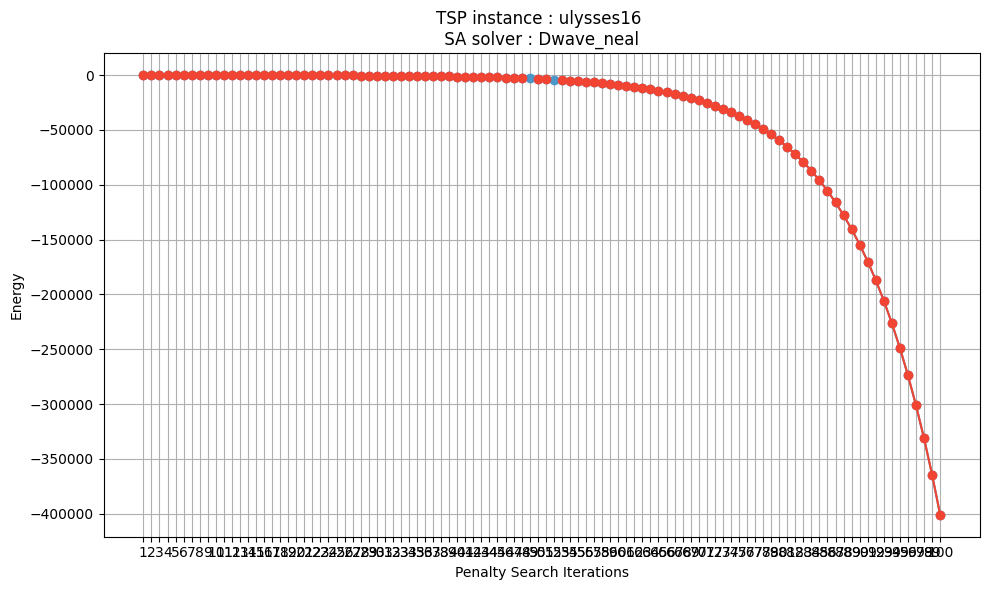

In [138]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 101))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list_all, marker='o', linestyle='-', color=plt.cm.Blues(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color=plt.cm.Reds(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n SA solver : Dwave_neal ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Energy')
plt.grid(True)
plt.xticks(iterations)
# plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [146]:
min_distance_list_all_pp = [] 
for i in min_distance_list_all:
    if i == None:
        min_distance_list_all_pp.append(i)
    else:
        min_distance_list_all_pp.append(100*i)



In [151]:
print(min_distance_list_all_pp)

#[8488.709478481851, 8520.58553754062, 9605.21425369409, 9052.797050089073, 9086.260023427496, 8124.028875899345, 9832.523596368917, 10627.311621255272, 11508.122700845255, 11270.710328307692, 10328.792313992879, 8182.333648591354, 10352.487592716456, 10049.80217149611, 8468.088925652768, 10741.566819273161, 8597.969957730907, 10071.168208318666, 10393.279412578015, 11967.81766495574, 9711.231927527391, 12135.01260306279, 9906.140855158732, 10534.161848585321, 11737.712496869686, 13574.41649039834, 10936.080880007992, 10584.74276163316, 10763.047987658221, 11838.52456883064, 12192.589798495657, 10941.034584024634, 10466.101539364094, 10366.565694660061, 11062.941682924164, 12488.48727023871, 11968.776478713415, 12308.839018909568, 11024.224477346817, 9849.374464729955, 11180.086694811134, 12543.330763118733, 10794.491569786474, 11425.897998842835, 11395.876254100564, 12053.581114325398, 10229.57618795818, 12106.779225805418, None, 11391.572137735138, 11931.880156567408, None, 11407.277330613848, 12018.884045821062, 10473.294723140456, 9173.92360082251, 10218.06204162111, 10611.358018380799, 10994.11742233934, 11414.75950928518, 10425.814385698486, 11955.62488790963, 10904.008466665378, 10367.146357106249, 11408.900172142863, 11327.932882107516, 10441.43869194146, 10770.663474852037, 11176.952073638342, 9380.614030448744, 9855.283868750628, 11066.460210193876, 10881.919138309735, 11638.97978972855, 11753.37823831909, 11128.98191044149, 11749.407395521, 12708.605208073133, 10376.357252357706, 10950.52600223149, 11114.177124069456, 12495.798381727956, 9155.275446361045, 10269.661846264622, 11581.542452126376, 12536.767770974908, 11736.582424676957, 10655.895084783238, 11164.261537437807, 10971.72982776424, 11389.8511168489, 12509.700043963454, 12169.964525265106, 10238.099628083084, 11710.642644595862, 11973.896129441913, 12553.133115012834, 9418.596260171262, 11618.536035493125, 10547.486314404208]


[8488.709478481851, 8520.58553754062, 9605.21425369409, 9052.797050089073, 9086.260023427496, 8124.028875899345, 9832.523596368917, 10627.311621255272, 11508.122700845255, 11270.710328307692, 10328.792313992879, 8182.333648591354, 10352.487592716456, 10049.80217149611, 8468.088925652768, 10741.566819273161, 8597.969957730907, 10071.168208318666, 10393.279412578015, 11967.81766495574, 9711.231927527391, 12135.01260306279, 9906.140855158732, 10534.161848585321, 11737.712496869686, 13574.41649039834, 10936.080880007992, 10584.74276163316, 10763.047987658221, 11838.52456883064, 12192.589798495657, 10941.034584024634, 10466.101539364094, 10366.565694660061, 11062.941682924164, 12488.48727023871, 11968.776478713415, 12308.839018909568, 11024.224477346817, 9849.374464729955, 11180.086694811134, 12543.330763118733, 10794.491569786474, 11425.897998842835, 11395.876254100564, 12053.581114325398, 10229.57618795818, 12106.779225805418, None, 11391.572137735138, 11931.880156567408, None, 11407.2773

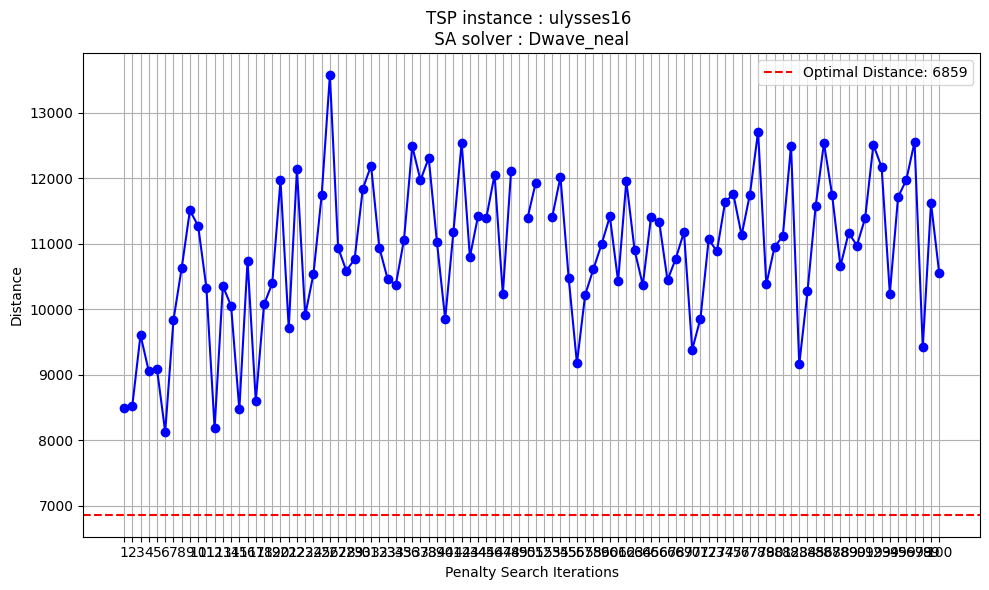

In [147]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 101))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_distance_list_all_pp, marker='o', linestyle='-', color='b') #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")
plt.axhline(y=6859, color='red', linestyle='--', label="Optimal Distance: 6859")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n SA solver : Dwave_neal ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Distance')
plt.grid(True)
plt.xticks(iterations)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
